In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import beta

### sources about bayesian analysis with beta priors

http://chrisstrelioff.ws/sandbox/2014/12/11/inferring_probabilities_with_a_beta_prior_a_third_example_of_bayesian_calculations.html

http://www.quantstart.com/articles/Bayesian-Inference-of-a-Binomial-Proportion-The-Analytical-Approach

https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/

In [2]:
class Beta:
    def __init__(self, alpha0=1, alpha1=1):
        """Beta prior for binary data."""
        self.a0 = alpha0
        self.a1 = alpha1
        self.p0rv = beta(self.a0, self.a1)

    def interval(self, prob):
        """End points for region of pdf containing `prob` of the
        pdf-- this uses the cdf and inverse.

        Ex: interval(0.95)
        """
        return self.p0rv.interval(prob)

    def mean(self):
        """Returns prior mean."""
        return self.p0rv.mean()

    def pdf(self, p0):
        """Probability density at p0."""
        return self.p0rv.pdf(p0)

    def plot(self, ax, name='', color='red', label='', fillAlpha=0.1):
        """A plot showing mean and 95% credible interval."""
        x = np.arange(0., 1., 0.001)

        # get prior mean p0
        mean = self.mean()

        # get low/high pts containg 95% probability
        low_p0, high_p0 = self.interval(0.95)
        x_prob = np.arange(low_p0, high_p0, 0.01)

        # plot pdf
        ax.plot(x, self.pdf(x), '-', color=color, label=label)

        # fill 95% region
        ax.fill_between(x_prob, 0, self.pdf(x_prob), color=color, alpha=fillAlpha, label='_nolegend_')

        # mean
        _, stemlines, _ = ax.stem([mean], [self.pdf(mean)], linefmt='--', markerfmt=' ')
        plt.setp(stemlines, 'color', color)

        ax.set_xlabel(name, fontsize=24)
        ax.set_ylabel('PDF')
        ax.set_ylim(0., 1.1*np.max(self.pdf(x)))
        
        return ax
    

### Read data

In [3]:
df = pd.read_csv('data.csv', sep=';')

In [4]:
df.columns

Index(['Id', 'Session', 'Task', 'Question', 'Choice1', 'Choice2', 'Answer',
       'Timestamp', 'Session_id', 'Session_ini', 'Session_end', 'Lang',
       'Group', 'Hiking', 'Gaming', 'Comments'],
      dtype='object')

In [5]:
methods = ['B', 'V', 'D', 'VD', 'VDE']
#methods = ['B', 'V', 'D', 'VD']
colors = ['blue', 'red', 'green', 'orange', 'purple', 'sienna', 'dimgray', 'darkturquoise', 'olive', 'rosybrown']

### Group info by participant

In [6]:
participants = {}

for _,row in df.iterrows():
    
    sid   = row['Session_id']
    
    if sid not in participants:
        tini = datetime.strptime(row['Session_ini'], '%Y-%m-%d %H:%M:%S.%f')
        try:
            tend = datetime.strptime(row['Session_end'], '%Y-%m-%d %H:%M:%S.%f')
        except:
            tend = None
            
        # session stats
        participants[sid] = {
            'lang': row['Lang'],
            'group': row['Group'],
            'hike': int(row['Hiking']),
            'game': int(row['Gaming']),
            'tini': tini,
            'tend': tend,
            'time': (tend - tini).total_seconds()/60.0 if tend else None
        }
        # tasks (just 1 in this study)
        participants[sid][1] = {
            'questions': [],
            'answers': []
        }
        
    task = row['Task']
    opt1 = row['Choice1']
    opt2 = row['Choice2']
    ans  = row['Answer']
    participants[sid][task]['questions'].append((opt1, opt2))
    participants[sid][task]['answers'].append(ans)
    

### Filter samples based on conditions about participants

In [7]:
keepOnlyCompleted = True
gamingFreq = [0, 1, 2, 3, 4] # all
hikingFreq = [0, 1, 2, 3, 4] # all
groups = [] # leave empty for all
minConsistency = 1 # 0, 1 or 2. 0 will keep all participants. 2 will keep those that matched both control questions 

In [8]:
demographics = np.zeros((5,5))
consistencyQuestions = []
samplesTask1 = []
nskip = 0

for sid,p in participants.items():
    
    skip = False
    
    # filter participants that completed the study
    if keepOnlyCompleted and not p['tend']:
        print('Participant', sid, 'not completed')
        skip = True
        
    # filter based on habits
    if p['game'] not in gamingFreq:
        print('Participant', sid, 'gaming')
        skip = True
    if p['hike'] not in hikingFreq:
        print('Participant', sid, 'hiking')
        skip = True
        
    # filter based on test group
    if len(groups) > 0 and p['group'] not in groups:  
        print('Participant', sid, 'not in groups')
        skip = True
    
    # consistency
    numQT1 = len(p[1]['questions'])
    qconsistency = [False for _ in range(numQT1)]
    nconsistency = 0
    tconsistency = 0
    cquestions = []
    changedAnswers = []
    for i in range(numQT1):
        if qconsistency[i]:
            continue            
        q1, q2 = p[1]['questions'][i]
        for j in range(i+1, numQT1):
            c1, c2 = p[1]['questions'][j]
            if (q1 == c1 and q2 == c2) or (q1 == c2 and q2 == c1):
                sameAnswer = p[1]['answers'][i] == p[1]['answers'][j]
                qconsistency[j] = True
                tconsistency += 1
                nconsistency += 1 if sameAnswer else 0
                cquestions.append(((q1, q2), sameAnswer))
                if not sameAnswer:
                    changedAnswers.append(j)
        
    if tconsistency > 0 and nconsistency < minConsistency:
        print('Participant', sid, 'consistency', nconsistency, p['group'])
        skip = True

        
    # skip
    if skip:
        #print('  Skip participant', sid)
        nskip += 1
        continue
    
    demographics[p['hike']][p['game']] += 1
    for c in cquestions:
        consistencyQuestions.append(c)
        
    # or keep answers
    for i in range(numQT1):
        if not qconsistency[i] or i in changedAnswers:
            samplesTask1.append((p[1]['questions'][i], p[1]['answers'][i]))

Participant 24 not completed
Participant 33 not completed
Participant 34 not completed
Participant 36 not completed
Participant 39 not completed
Participant 46 not completed
Participant 49 not completed
Participant 49 consistency 0 fmc
Participant 51 not completed
Participant 64 not completed
Participant 78 consistency 0 ccc
Participant 79 not completed
Participant 81 consistency 0 ccc
Participant 82 not completed
Participant 84 not completed
Participant 85 not completed
Participant 88 consistency 0 ccc
Participant 93 consistency 0 ccc
Participant 95 not completed
Participant 96 not completed
Participant 98 not completed
Participant 107 not completed
Participant 108 not completed
Participant 122 consistency 0 vrv
Participant 125 not completed
Participant 137 not completed
Participant 143 consistency 0 vrv
Participant 146 consistency 0 vrv
Participant 154 not completed
Participant 161 not completed


In [9]:
print('Participants', len(participants.keys()))
print('Num skipped', nskip)
print('Considered', len(participants.keys()) - nskip)
print('Samples T1', len(samplesTask1))

Participants 145
Num skipped 29
Considered 116
Samples T1 2368


In [10]:
print(demographics[1:,1:])

[[ 1.  1.  0.  1.]
 [16.  6.  6.  3.]
 [11.  8.  5.  1.]
 [39.  6.  4.  8.]]


## Consistency analysis

In [11]:
changesDistributions = {}
for m1 in methods:
    for m2 in methods:
        changesDistributions[(m1, m2)] = np.array([1,1])

for (choice1,choice2),sameAnswer in consistencyQuestions:
    m1 = choice1.split('_')[1]
    m2 = choice2.split('_')[1]
    changesDistributions[(m1, m2)] += np.array([not sameAnswer, sameAnswer]) 
    changesDistributions[(m2, m1)] += np.array([not sameAnswer, sameAnswer]) 

In [12]:
for i,m1 in enumerate(methods):
    for j in range(i+1, len(methods)):
        m2 = methods[j]
        
        achange, asame = changesDistributions[(m1, m2)]
        
        print(m1, 'vs', m2, ':', changesDistributions[(m1, m2)], '%.2f changes'%(achange/(achange + asame)))

B vs V : [ 6 21] 0.22 changes
B vs D : [ 6 24] 0.20 changes
B vs VD : [ 9 20] 0.31 changes
B vs VDE : [ 3 18] 0.14 changes
V vs D : [ 9 18] 0.33 changes
V vs VD : [ 3 22] 0.12 changes
V vs VDE : [ 4 20] 0.17 changes
D vs VD : [ 6 19] 0.24 changes
D vs VDE : [ 5 12] 0.29 changes
VD vs VDE : [ 7 21] 0.25 changes


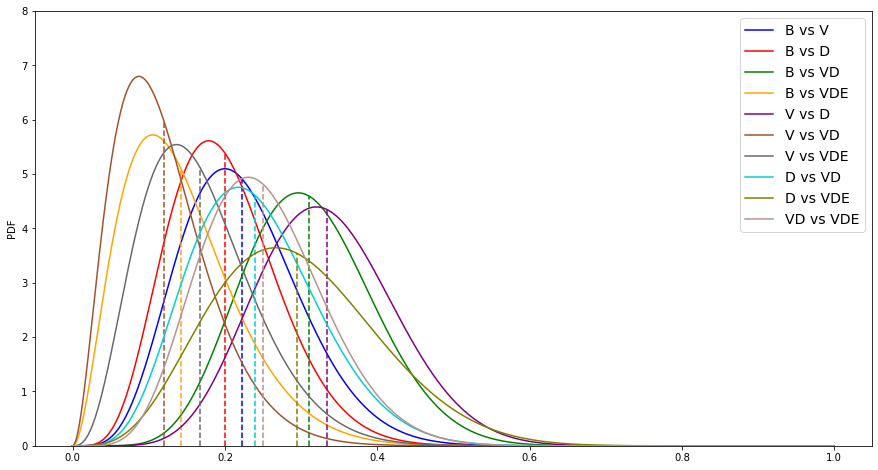

In [13]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

names = []
idx = 0
for i,m1 in enumerate(methods):
    for j in range(i+1, len(methods)):
        m2 = methods[j]
        
        names.append(m1 + ' vs ' + m2)
        d = changesDistributions[(m1, m2)]
        b = Beta(d[0], d[1])
        b.plot(ax, color=colors[idx], fillAlpha=0)
        idx += 1


ax.set_ylim(0., 8)
ax.legend(names, loc='upper right', fontsize=14)

## Global analysis

### Initialize priors

In [14]:
# initialize each method prior as a uniform Beta(1,1), flat and uninformative (i.e. no prior assumptions made)
distributions = {}
for m in methods:
    distributions[m] = np.array([1,1])

### Update posteriors

In [15]:
# iterate rows and update the beta distributions of the pair as follows:
#   if chosen: Beta(a,b) --> Beta(a+1, b)
#   otherwise: Beta(a,b) --> Beta(a, b+1)

for (choice1,choice2),answer in samplesTask1:
    
    # get method dictionary names
    m1 = choice1.split('_')[1]
    m2 = choice2.split('_')[1]
    mr = answer.split('_')[1]
    
    if m1 not in distributions.keys() or m2 not in distributions.keys():
        continue
    
    # update Beta
    distributions[m1] += np.array([m1 == mr, m1 != mr])
    distributions[m2] += np.array([m2 == mr, m2 != mr])
    

In [16]:
print(distributions)

{'B': array([463, 487]), 'V': array([394, 554]), 'D': array([566, 386]), 'VD': array([580, 371]), 'VDE': array([370, 575])}


### Plots

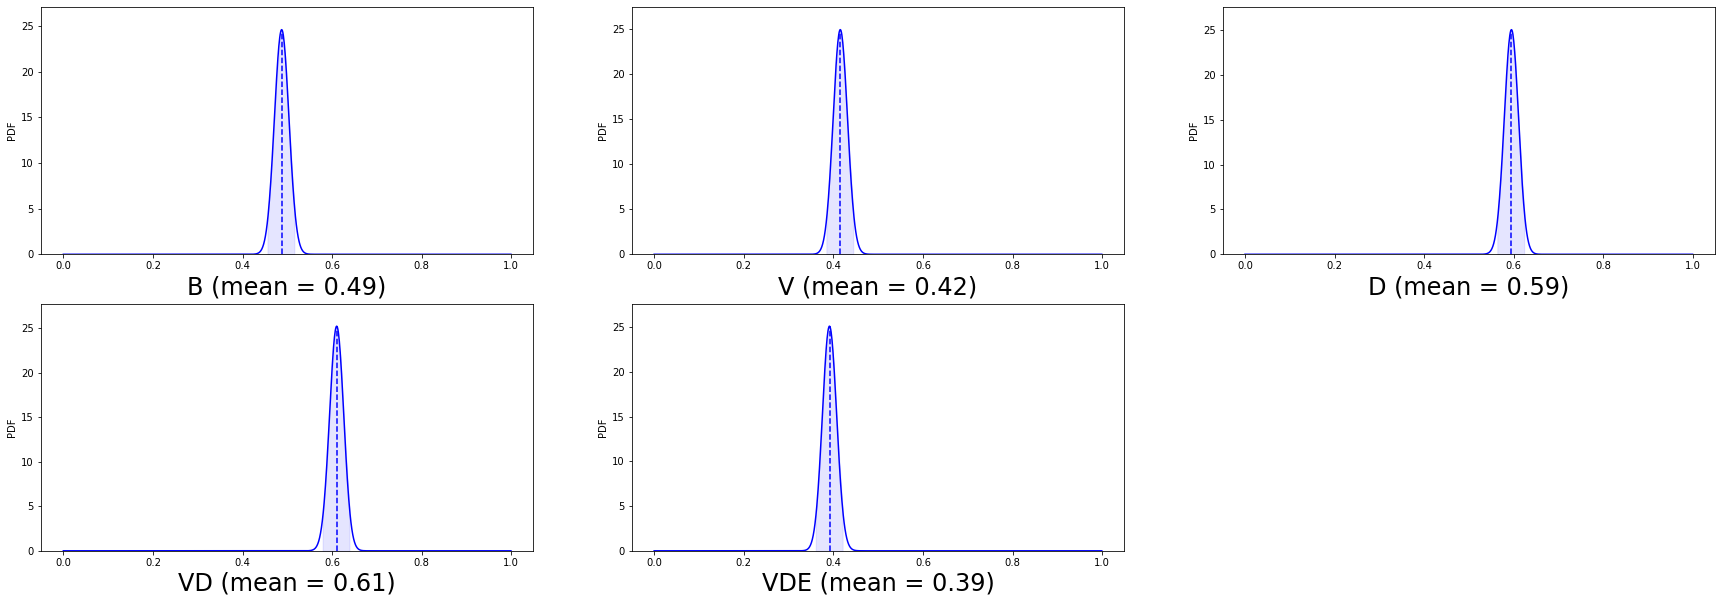

In [17]:
fig = plt.figure(figsize=(30,10))

idx = 1
for method,d in distributions.items():
    ax = fig.add_subplot(230 + idx)
    b = Beta(d[0], d[1])
    b.plot(ax, method + ' (mean = %.2f)'%b.mean(), color='blue')
    idx += 1

In [18]:
fig.savefig('dists.png', dpi=120, bbox_inches='tight', pad_inches=0)

In [19]:
def plotDistributions(distributions, ax, title):
    names = []
    idx = 0
    for method,d in distributions.items():
        names.append(method)
        b = Beta(d[0], d[1])
        b.plot(ax, color=colors[idx])
        idx += 1

    ax.set_title(title, fontsize=16, fontfamily='sans-serif', fontstyle='normal')
    ax.set_xlabel('probability of being selected', fontsize=14)
    ax.set_ylabel('')
    #ax.set_ylim(0., 10)
    ax.legend(names, loc='upper right', fontsize=14)
    
    

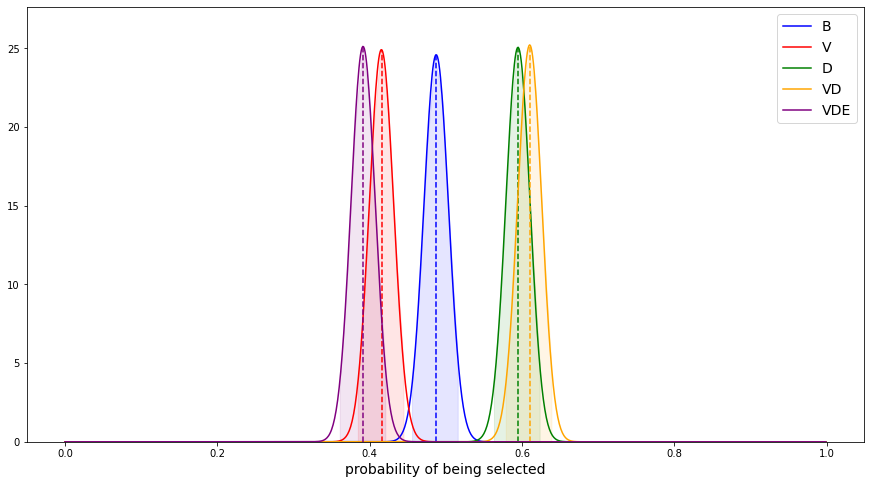

In [20]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

plotDistributions(distributions, ax, '')

In [21]:
fig.savefig('dists.png', dpi=120, bbox_inches='tight', pad_inches=0)

## Paired analysis

In [22]:
pairDistributions = {}
pairKeys = {} # from method pair (any order) -> key name
pairVals = {} # from method pair (any order) -> which one is plotted

for i in range(len(methods)):
    mi = methods[i]
    for j in range(i+1, len(methods)):
        mj = methods[j]
        
        pairName = mi + ' vs ' + mj
        
        pairDistributions[pairName] = np.array([1,1])
        
        pairKeys[(mi, mj)] = pairName
        pairKeys[(mj, mi)] = pairName
        pairVals[(mi, mj)] = mi
        pairVals[(mj, mi)] = mi

In [23]:
pairMethods = pairDistributions.keys()
print(pairMethods)

dict_keys(['B vs V', 'B vs D', 'B vs VD', 'B vs VDE', 'V vs D', 'V vs VD', 'V vs VDE', 'D vs VD', 'D vs VDE', 'VD vs VDE'])


In [24]:
print(pairKeys)

{('B', 'V'): 'B vs V', ('V', 'B'): 'B vs V', ('B', 'D'): 'B vs D', ('D', 'B'): 'B vs D', ('B', 'VD'): 'B vs VD', ('VD', 'B'): 'B vs VD', ('B', 'VDE'): 'B vs VDE', ('VDE', 'B'): 'B vs VDE', ('V', 'D'): 'V vs D', ('D', 'V'): 'V vs D', ('V', 'VD'): 'V vs VD', ('VD', 'V'): 'V vs VD', ('V', 'VDE'): 'V vs VDE', ('VDE', 'V'): 'V vs VDE', ('D', 'VD'): 'D vs VD', ('VD', 'D'): 'D vs VD', ('D', 'VDE'): 'D vs VDE', ('VDE', 'D'): 'D vs VDE', ('VD', 'VDE'): 'VD vs VDE', ('VDE', 'VD'): 'VD vs VDE'}


In [25]:
for (choice1,choice2),answer in samplesTask1:
    
    # get method dictionary names
    m1 = choice1.split('_')[1]
    m2 = choice2.split('_')[1]
    mr = answer.split('_')[1]
    
    if (m1,m2) not in pairKeys.keys():
        continue
    
    # update Beta
    key = pairKeys[(m1, m2)]
    val = pairVals[(m1, m2)]
    pairDistributions[key] += np.array([val == mr, val != mr])

In [26]:
print(pairDistributions)

{'B vs V': array([133, 106]), 'B vs D': array([100, 139]), 'B vs VD': array([ 94, 148]), 'B vs VDE': array([139,  97]), 'V vs D': array([ 84, 158]), 'V vs VD': array([ 79, 157]), 'V vs VDE': array([128, 109]), 'D vs VD': array([131, 108]), 'D vs VDE': array([141,  97]), 'VD vs VDE': array([170,  70])}


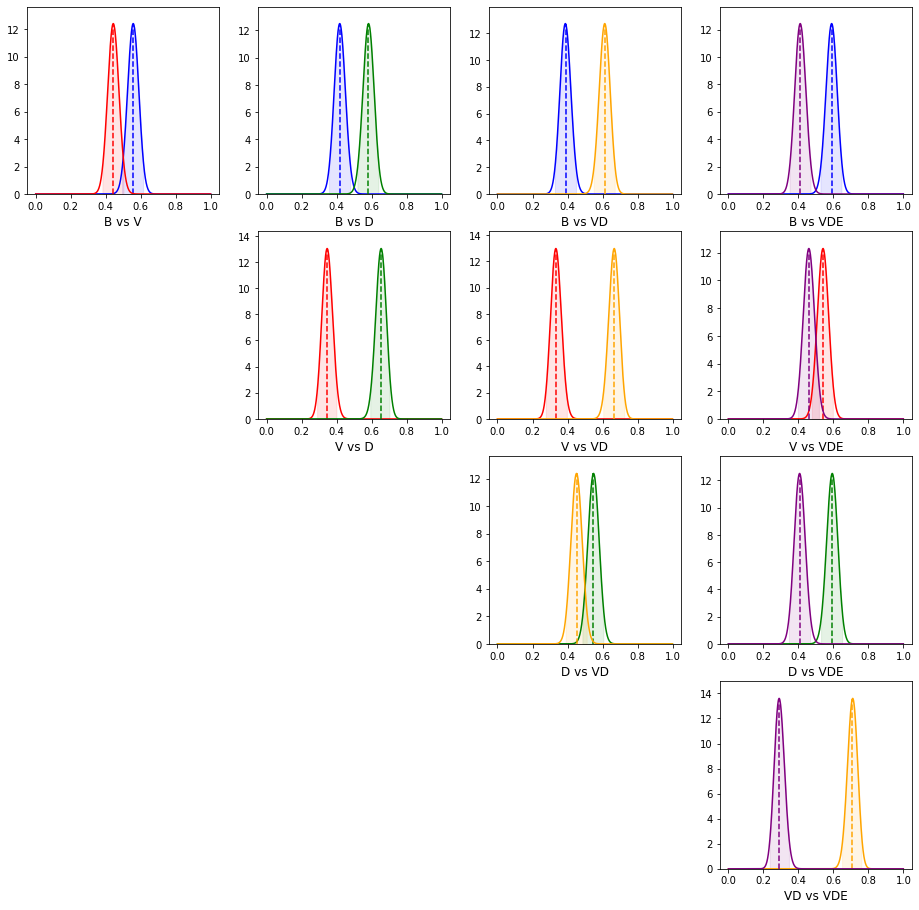

In [27]:
fig = plt.figure(figsize=(20,20))

idx = 1
for i in range(5):
    
    mi = methods[i]
    ci = colors[i]
    
    for j in range(i+1, 5):
        
        mj = methods[j]
        cj = colors[j]
        
        ax = plt.subplot2grid((5,5), (i,j))
    
        name = pairKeys[(mi, mj)]
        d = pairDistributions[name]
        bi = Beta(d[0], d[1])
        bj = Beta(d[1], d[0])
       
        bi.plot(ax, color=colors[i], label=mi)
        bj.plot(ax, color=colors[j], label=mj)
        ax.set_xlabel(name, fontsize=12)
        ax.set_ylabel(None)

In [28]:
fig.savefig('pairedDists.png', dpi=120, bbox_inches='tight', pad_inches=0)